# London Cycling Project

### Load datasets

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
# Ignore copy warning
pd.options.mode.chained_assignment = None 

In [2]:
# Load London data 
inner = pd.read_csv('London/inner.csv')
outer = pd.read_csv('London/Outer London.csv')
central = pd.read_csv('London/central.csv')
sites = pd.read_excel('London/Biking sites.xlsx')

In [3]:
# Set up Easting/Northing to Latitude/Longitude converter
transformer = Transformer.from_crs('epsg:27700', 'epsg:4326')

# Get coordinates of sites 
sites['coordinates'] = ''
for i in range(sites.shape[0]):
    sites['coordinates'][i] = transformer.transform(sites.Easting[i], sites.Northing[i])

In [4]:
# Add columns 
central['area'] = 'Central'
inner['area'] = 'Inner'
outer['area'] = 'Outer'
central['Survey wave (year)'] = [central['Survey wave (calendar quarter)'][i].split()[0] 
                                 for i in range(central.shape[0])]

In [5]:
# Join London dataframes 
london = pd.concat([central, inner, outer]).reset_index(drop=True)

In [6]:
# Get day of week and date from survey date column

london['Survey date'].replace(' ', np.NaN, inplace=True)
london['Survey date'] = london['Survey date'].fillna(', ')

london['days'] = [london['Survey date'][i].split(', ')[0] for i in range(london.shape[0])]
london['date'] = [london['Survey date'][i].split(', ')[1] for i in range(london.shape[0])]

london['Survey date'].replace(', ', np.NaN, inplace=True)

day_mapping = {
    'lun' : 'Monday',
    'mar' : 'Tuesday',
    'mer' : 'Wednesday',
    'jeu' : 'Thursday',
    'ven' : 'Friday',
    'sam' : 'Saturday',
    'dim' : 'Sunday',
    '' : np.NaN
}

london['day_of_week'] = london['days'].map(day_mapping)
london.date.replace('', np.nan, inplace=True)
london.drop(['Survey date', 'days'], axis=1, inplace=True)

In [7]:
# Drop columns that may be less important in analysis 
london = london.drop(['Survey wave (calendar quarter)', 'Equivalent financial quarter', 'Location', 
                      'Time', 'Direction', 'Start minute', 'Number of unknown cycles'], axis=1)

In [8]:
# Rename columns 
london.rename(columns={'Site ID':'site', 'Weather':'weather', 'Period':'period', 'Start hour':'hour', 
                       'Number of private cycles':'private', 'Number of cycle hire bikes':'hired', 
                       'Total cycles':'total_cycles', 'Survey wave (year)':'year', 'Number of male cycles':'male',
                       'Number of female cycles':'female'}, inplace=True)

In [9]:
# Standardise weather 
london.weather = london.weather.str.lower()
london.weather = london.weather.fillna('')

wet_list = ['wet', 'rain', 'drizz', 'shower', 'damp', 'mizzle', 'down pour', 'deluge', 'spit', ' shr']
good_list = ['sun', 'fine', 'fair', 'warm', 'hot', 'good', 'mild', 'clear', 'bright']
poor_list = ['cloud', 'overcast', 'cold', 'cool', 'wind', 'dull', 'dark', 'chill', 'hazy', 'foggy', 
             'blustery', 'mist', 'snow', 'hail', 'sleet', 'storm', 'thunder']

weather_cat = []
for weather_text in london.weather:
    if any(word in weather_text for word in wet_list) and 'dry' in weather_text:
        weather_cat.append('mixed')
    elif 'dry' in weather_text:
        weather_cat.append('dry')
    elif any(word in weather_text for word in wet_list):
        weather_cat.append('wet')
    elif (any(word in weather_text for word in good_list) and any(word in weather_text for word in poor_list)) or weather_text == 'mixed':
        weather_cat.append('mixed')       
    elif any(word in weather_text for word in good_list):
        weather_cat.append('good')        
    elif any(word in weather_text for word in poor_list):
        weather_cat.append('poor')       
    else:
        weather_cat.append(np.nan)    
        
london['weather'] = weather_cat

In [10]:
# Convert date data 
london['date'] = pd.to_datetime(london['date'], errors='coerce')
london['month'] = london['date'].dt.month

# Convert year from object to integer type
london = london.astype({'year':'int'})

In [11]:
# Get borough and coordinate data  
site_data = sites[['UnqID', 'Borough', 'coordinates']].rename(columns={'UnqID':'site', 'Borough':'borough'})
london = london.merge(site_data, how='left', on='site')

In [12]:
# Checking for unexpected values 
for col in london.columns:
    print(london[col].value_counts())

# Checking null values 
london.isna().sum()

# View dataset
london.head()

CENCY008    3714
CENCY001    3712
CENCY136    3712
CENCY125    3712
CENCY126    3712
            ... 
INNCY479     640
INNCY492     640
INNCY455     640
INNCY463     640
INNCY502     640
Name: site, Length: 1258, dtype: int64
dry      1385589
wet       194965
good       37002
poor       13044
mixed       4637
Name: weather, dtype: int64
Inter-peak (10:00-16:00)       621642
AM peak (07:00-10:00)          310824
PM peak (16:00-19:00)          310781
Evening (19:00-22:00)          310738
Early Morning (06:00-07:00)    103608
Name: period, dtype: int64
6.0     103608
7.0     103608
8.0     103608
9.0     103608
10.0    103608
11.0    103608
12.0    103608
13.0    103608
14.0    103605
15.0    103605
16.0    103604
18.0    103589
17.0    103588
19.0    103584
20.0    103580
21.0    103574
Name: hour, dtype: int64
0.0      200509
1.0      144984
2.0      117913
3.0       93606
4.0       80113
          ...  
476.0         1
362.0         1
428.0         1
512.0         1
378.0         1
Nam

,site,weather,period,hour,private,hired,total_cycles,area,year,male,female,date,day_of_week,month,borough,coordinates
0,CENCY001,dry,Early Morning (06:00-07:00),6.0,0.0,0.0,0,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"
1,CENCY001,dry,Early Morning (06:00-07:00),6.0,15.0,0.0,15,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"
2,CENCY001,dry,Early Morning (06:00-07:00),6.0,35.0,0.0,35,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"
3,CENCY001,dry,Early Morning (06:00-07:00),6.0,59.0,2.0,61,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"
4,CENCY001,dry,AM peak (07:00-10:00),7.0,73.0,0.0,73,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"


In [13]:
# Consider handling NaN values

### Differences

We observe that there are more male than female cyclists, and more cyclists using private than hired bicycles.
What are the possible reasons for this? Can we make any recommendations to increase cycling levels?

Text(0.5, 0, 'Number of cyclists')

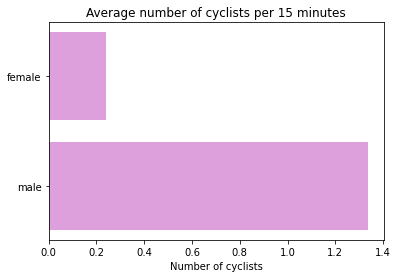

In [14]:
# Male vs female cyclists (Outer London)
sex_df = pd.DataFrame(london[['male', 'female']].mean(), columns=['mean']).reset_index()
plt.barh(sex_df['index'], sex_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

Text(0.5, 0, 'Number of cyclists')

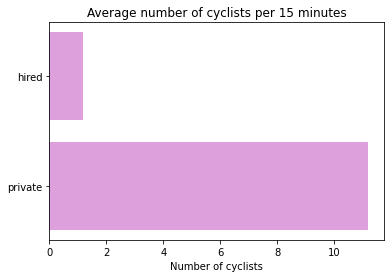

In [15]:
# Private vs hired cycles (Inner and Central London)
private_df = pd.DataFrame(london[['private', 'hired']].mean(), columns=['mean']).reset_index()
plt.barh(private_df['index'], private_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

In [16]:
# Consider significance tests

### Modelling

We would like to predict the number of cyclists in a 15 minute period, based on the features available. We would then like to extend this model to look at the proximity to various infrastructure, based on the coordinates.

In [17]:
# Select features for model 
london_model = london[['year', 'month', 'day_of_week', 'period', 'hour', 'area', 'borough', 'weather', 'total_cycles']]
london_model.head()

,year,month,day_of_week,period,hour,area,borough,weather,total_cycles
0,2014,1.0,Friday,Early Morning (06:00-07:00),6.0,Central,Westminster,dry,0
1,2014,1.0,Friday,Early Morning (06:00-07:00),6.0,Central,Westminster,dry,15
2,2014,1.0,Friday,Early Morning (06:00-07:00),6.0,Central,Westminster,dry,35
3,2014,1.0,Friday,Early Morning (06:00-07:00),6.0,Central,Westminster,dry,61
4,2014,1.0,Friday,AM peak (07:00-10:00),7.0,Central,Westminster,dry,73


### Plan for London data:

#### Steps completed:
- build some basic plots to show differences in cyclists (male/female, private/hired)
- use Python package (geopy?) to get coordinates of count sites 

#### Steps in progress / to do: 
- build a model to show differences in cyclists (weather? area? hour?)
- clean and join infrastructure data to london data using coordinates 
- build a model to show differences in cyclists with this new data 